## Clase 07 - Cálculo de la componente de marea M2
**Temas Selectos de Modelación Numérica** <br>
Facultad de Ciencias, UNAM <br>
Semestre 2021-2

En este notebook calcularemos la componente M2 de la marea en Acapulco. El [Servicio Mareográfico Nacional](http://www.mareografico.unam.mx/portal/) (SMN) se encarga de medir la altura del nivel del mar en diversas estaciones en las costas del país y pone a disposición del público los datos recabados. 

Las principales componentes de marea en Acapulco segun el SMN son:

|Componente|      H          |   Fase en grados 90W  | Periodo en h |Amplitud de este ejemplo (cm)|
|:-:|:-:|:-:|:-:|:-:|
 |M2| 0.185 m |  57.37 |  12.4206012|    0.18994275693721   |
 |S2| 0.082 m |  239.80| 12          |  0.0808895368206989  |
 |N2| 0.057 m |  6.52   | 12.65834751|   0.0523977003965733  |
 |K2| 0.024 m |  244.47 | 11.96723606|   0.0169209285723706  |
 |K1| 0.117 m |  53.65  | 23.93447213|   0.110433419381075|
 |O1| 0.090 m |  64.06  | 25.81933871|  0.0811696918005651|
 |P1| 0.038 m |  53.66  | 14.9589314 |   0.000781365644816317|
 
 -------
 Main harmonic constituents at La Jolla (https://tidesandcurrents.noaa.gov/harcon.html?unit=0&timezone=1&id=9410230&name=La+Jolla&state=CA)

|Number|Name|Amplitude (m)|Phase (deg)|Speed (deg/hr)|Period (hr)|Description|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|	M2|	0.5	|270.1|	28.984104|12.420601|	Principal lunar semidiurnal constituent|
|2|	S2|	0.204|	258.5|	30.0| 12.0| Principal solar semidiurnal constituent|
|3|	N2|	0.117|	254.1|	28.43973|12.658348|	Larger lunar elliptic semidiurnal constituent|
|4|	K1|	0.332|	86.6|	15.041069| 23.934469|	Lunar diurnal constituent|
|6|	O1|	0.213|	80.2|	13.943035|25.819343|Lunar diurnal constituent|


**Constituent #** Order in which the National Ocean Service lists the constituents 

**Name** Common name used to refer to a particular constituent, subscript refers to the number of cycles per day

**Amplitude** One-half the range of a tidal constituent

**Phase** The phase lag of the observed tidal constituent relative to the theoretical equilibrium tide

**Speed** The rate change in the phase of a constituent, expressed in degrees per hour. The speed is equal to 360 degrees divided by the constituent period expressed in hours

**Period** 360/Speed, period in hours.

**Description** The full name of the tidal constituent



Primero, importemos las bibliotecas necesarias para nuestro análisis:

In [13]:
# Las que ya hemos usado:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

# Nuevas 
import datetime as dt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from scipy import signal

### Lee datos de marea

Text(0.5, 1.0, 'LaJolla, jan 2016')

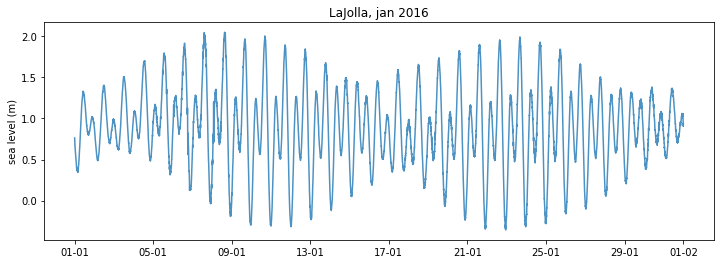

In [5]:
col_names = ["Date","Time","Predicted","Preliminary","Verified"]
stations=['LaJolla','LosAngeles','SantaMonica','SantaBarbara','PortSanLuis']
st_ids = ['9410230','9410660','9410840','9411340','9412110']
months = ['jan','feb','mar','apr','may','jun','jul','aug']

# select 1 month, 1 station
st_id = st_ids[0]
month = months[0]
station = stations[0]

# read data
directory = '/Users/Karina/Research/SVB/NOAA-seaLevel/' + station 
filename = directory + '/CO-OPS_' + st_id + '_met_' + month + '.csv'
data = pd.read_csv(filename, parse_dates=[['Date', 'Time']], names=col_names) 
data['datetime'] = pd.to_datetime(data['Date_Time'][1:], format='%Y/%m/%d %H:%M')
data_new = data.set_index('datetime')
ssh = pd.to_numeric(data_new['Verified'], errors='coerce')

# plot
fig,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(ssh, alpha=0.8, label=station)
ax.set_ylabel('sea level (m)') 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('%s, %s 2016' %(station,month))

### Componentes de marea

Empecemos por definir las frecuencias de cada una de las principales componentes de marea:

In [4]:
# frequencies
w_M2 =  2*np.pi/(12.420601*60*60);
w_S2 =  2*np.pi/(12*60*60);
w_N2 =  2*np.pi/(12.658348*60*60);
w_K1 =  2*np.pi/(23.934469*60*60);
w_O1 =  2*np.pi/(25.819343*60*60);

In [6]:
# Time vector of seconds (generate timedelta vector and convert to seconds)
T = (data['datetime'][1:]-data['datetime'][1])/ np.timedelta64(1, 's')
T[1] = 1

# generate matrix
H = np.array((T/T, np.sin(w_M2*T), np.cos(w_M2*T) , np.sin(w_S2*T), np.cos(w_S2*T), np.sin(w_N2*T), 
             np.cos(w_N2*T), np.sin(w_K1*T), np.cos(w_K1*T), np.sin(w_O1*T), np.cos(w_O1*T)))
np.shape(H)
H_mat = H.T

In [7]:
# calculate components
A = np.linalg.inv(H_mat.T.dot(H_mat)).dot(H_mat.T).dot(ssh[1:])

level_M2 = [A[0] + A[1]*np.sin(w_M2*T) + A[2]*np.cos(w_M2*T) + A[3]*np.sin(w_S2*T) + 
            A[4]*np.cos(w_S2*T) + A[5]*np.sin(w_N2*T) + A[6]*np.cos(w_N2*T) + 
            A[7]*np.sin(w_K1*T) + A[8]*np.cos(w_K1*T) + A[9]*np.sin(w_O1*T) + A[10]*np.cos(w_O1*T)]

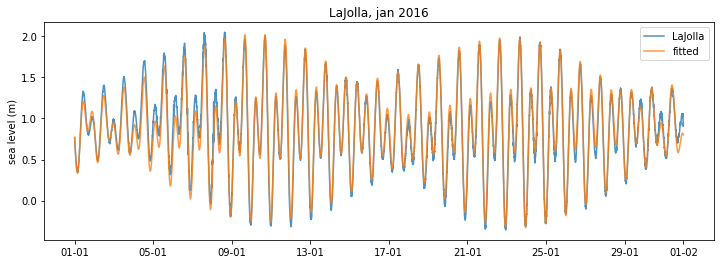

In [8]:
# Plot
fig,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(ssh.index, ssh, alpha=0.8, label=station)
ax.plot(ssh.index[1:], np.squeeze(level_M2), alpha=0.8, label='fitted')
ax.set_ylabel('sea level (m)') 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('%s, %s 2016' %(station,month))
ax.legend()

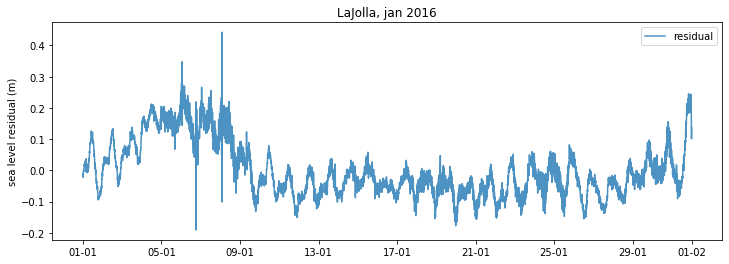

In [9]:
# Plot
fig,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(ssh.index[1:], ssh[1:]-np.squeeze(level_M2), alpha=0.8, label='residual')
ax.set_ylabel('sea level residual (m)') 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('%s, %s 2016' %(station,month))
ax.legend()

### Una construcción equivalente

In [10]:
### Probemos una cronstrucción equivante

C_M2 = np.sqrt(A[1]**2 + A[2]**2)  
C_S2 = np.sqrt(A[3]**2 + A[4]**2) 
C_N2 = np.sqrt(A[5]**2 + A[6]**2) 
C_K1 = np.sqrt(A[7]**2 + A[8]**2) 
C_O1 = np.sqrt(A[9]**2 + A[10]**2) 

Fase_M2 = np.arctan2(A[1],A[2]) 
Fase_S2 = np.arctan2(A[3],A[4]) 
Fase_N2 = np.arctan2(A[5],A[6]) 
Fase_K1 = np.arctan2(A[7],A[8]) 
Fase_O1 = np.arctan2(A[9],A[10]) 

B = (A[0] + C_M2*np.cos(w_M2*T-Fase_M2) + 
    C_S2*np.cos(w_S2*T-Fase_S2) + 
    C_N2*np.cos(w_N2*T-Fase_N2) + 
    C_K1*np.cos(w_K1*T-Fase_K1) + 
    C_O1*np.cos(w_O1*T-Fase_O1) )

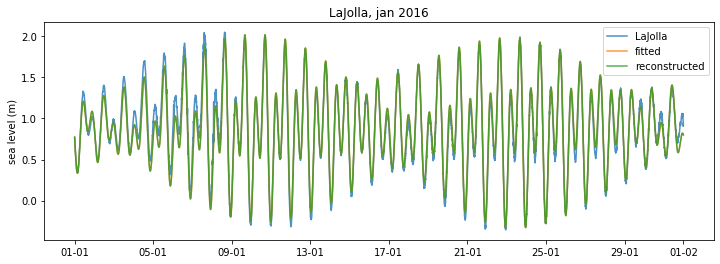

In [11]:
# Plot
fig,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(ssh.index, ssh, alpha=0.8, label=station)
ax.plot(ssh.index[1:], np.squeeze(level_M2), alpha=0.8, label='fitted')
ax.plot(ssh.index[1:], np.squeeze(B), alpha=0.8, label='reconstructed')

ax.set_ylabel('sea level (m)') 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('%s, %s 2016' %(station,month))
ax.legend()

### Espectro de frecuencias

/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


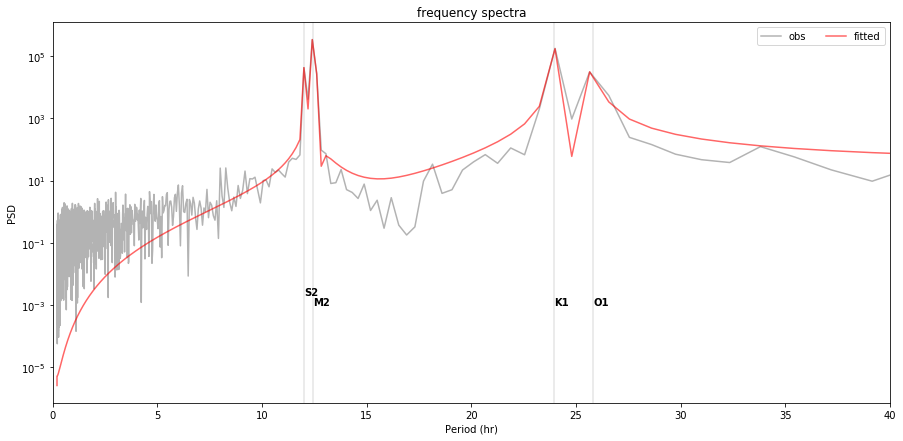

In [14]:
# Calulate periodograms
samp_freq = 1/(T[4]-T[3])
freq_fit, Pden_fit = signal.periodogram(np.squeeze(level_M2), samp_freq, detrend='constant')
freq_ssh, Pden_ssh = signal.periodogram(ssh[1:], samp_freq, detrend='constant')

fig,ax = plt.subplots(1,1, figsize=(15,7))

# Useful period indicators in hrs
ax.axvline(2*np.pi/(w_M2*3600), color='k', alpha=0.1, linestyle='-') 
ax.axvline(2*np.pi/(w_S2*3600), color='k', alpha=0.1, linestyle='-') 
ax.axvline(2*np.pi/(w_K1*3600), color='k', alpha=0.1, linestyle='-')  
ax.axvline(2*np.pi/(w_O1*3600), color='k', alpha=0.1, linestyle='-')  

ax.text(2*np.pi/(w_M2*3600),1E-3,'M2', fontweight='bold')
ax.text(2*np.pi/(w_S2*3600),2E-3,'S2', fontweight='bold')
ax.text(2*np.pi/(w_K1*3600),1E-3,'K1', fontweight='bold')
ax.text(2*np.pi/(w_O1*3600),1E-3,'O1', fontweight='bold')
 
# Plot in log scale
ax.semilogy((1/freq_ssh)/3600, Pden_ssh,'-',color='0.7', label='obs')
ax.semilogy((1/freq_fit)/3600, Pden_fit,'r-', alpha=0.6, label='fitted')

ax.set_ylabel('PSD')
ax.set_xlabel('Period (hr)')
ax.set_xlim(0,40)
ax.set_title('frequency spectra')
ax.legend(ncol=3)

### Ejercicio de tarea
Calcular un pronóstico de marea para Acapulco utilizando 8 componentes. https://en.wikipedia.org/wiki/Theory_of_tides#Tidal_constituents